# Diagnosing Bias and Variance

In the previous optional lab, you saw how to evaluate a learning algorithm's performance by measuring its training and cross validation error. Given these values, you are able to quantify how well a model is doing and this helps you make a decision on which one to use for a given application. In this lab, you will build upon this process and explore some tips to improve the performance of your models. As it turns out, the training and cross validation errors can tell you what to try next to improve your models. Specifically, it will show if you have a high bias (underfitting) or high variance (overfitting) problem. This lecture slide shown below gives an example:

<img src='../images/C2_W3_BiasVariance.png' width=75%>

The leftmost figure shows a high bias problem where the model is not capturing the patterns in the training data. As a result, you will have a high training and cross validation error. The rightmost figure, on the other hand, shows a high variance problem where the model has overfit the training set. Thus, even though it has a low training error, it will perform poorly on new examples. That is indicated by a high cross validation error. The ideal model would be the figure in the middle, where it successfully learns from the training set and also generalizes well to unseen data. The lectures gave some tips on what to do next to achieve this "just right" model. 

To fix a high bias problem, you can:
* try adding polynomial features
* try getting additional features
* try decreasing the regularization parameter

To fix a high variance problem, you can:
* try increasing the regularization parameter
* try smaller sets of features
* get more training examples

You will try all these tips in this lab. Let's begin!

## Establishing Baseline Level of Performance

Before you can diagnose a model for high bias or high variance, it is usually helpful to first have an idea of what level of error you can reasonably get to. As mentioned in class, you can use any of the following to set a baseline level of performance.

* human level performance
* competing algorithm's performance
* guess based on experience

Real-world data can be very noisy and it's often infeasible to get to 0% error. For example, you might think that you have a high bias problem because you're getting 10% training and 15% cross validation error on a computer vision application. However, you later found out that even humans can't perform better than 10% error. If you consider this the baseline level, then you now instead have a high variance problem because you've prioritized minimizing the gap between cross validation and training error.

With this in mind, let's begin exploring the techniques to address these issues.

## Imports and Lab Setup

Aside from a couple of [linear regressors](https://scikit-learn.org/stable/modules/classes.html#classical-linear-regressors) from scikit-learn, all other functions used in this lab are found in the `utils.py` file outside this notebook. You will mostly use the same code as the last lab so you don't need to see each line here again. It mostly contains functions to split your data, as well as functions that loop over a list of parameters (e.g. degree of polynomial, regularization parameter) and plots the training and cross validation error for each one. Feel free to explore the code in the said file to see the implementation.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.style.use('../deeplearning.mplstyle')

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# for building linear regression models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# import lab utility functions in utils.py
# import utils 

def prepare_dataset(filename):
    
    data = np.loadtxt(filename, delimiter=",")
    
    x = data[:,:-1]
    y = data[:,-1]
    
    # Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
    x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=80)

    # Split the 40% subset above into two: one half for cross validation and the other for the test set
    x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=80)
    
    return x_train, y_train, x_cv, y_cv, x_test, y_test


def train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=None):
    
    train_mses = []
    cv_mses = []
    models = []
    scalers = []
    degrees = range(1,max_degree+1)

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for degree in degrees:

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model.fit(X_train_mapped_scaled, y_train )
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    plt.plot(degrees, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(degrees, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.plot(degrees, np.repeat(baseline, len(degrees)), linestyle='--', label='baseline')
    plt.title("degree of polynomial vs. train and CV MSEs")
    plt.xticks(degrees)
    plt.xlabel("degree"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()


def train_plot_reg_params(reg_params, x_train, y_train, x_cv, y_cv, degree= 1, baseline=None):
    
    train_mses = []
    cv_mses = []
    models = []
    scalers = []

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for reg_param in reg_params:

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model = Ridge(alpha=reg_param)
        model.fit(X_train_mapped_scaled, y_train)
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    reg_params = [str(x) for x in reg_params]
    plt.plot(reg_params, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(reg_params, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.plot(reg_params, np.repeat(baseline, len(reg_params)), linestyle='--', label='baseline')
    plt.title("lambda vs. train and CV MSEs")
    plt.xlabel("lambda"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()

def train_plot_diff_datasets(model, files, max_degree=10, baseline=None):
    
    for file in files:
        
        x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset(file['filename'])

        train_mses = []
        cv_mses = []
        models = []
        scalers = []
        degrees = range(1,max_degree+1)

        # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
        for degree in degrees:

            # Add polynomial features to the training set
            poly = PolynomialFeatures(degree, include_bias=False)
            X_train_mapped = poly.fit_transform(x_train)

            # Scale the training set
            scaler_poly = StandardScaler()
            X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
            scalers.append(scaler_poly)

            # Create and train the model
            model.fit(X_train_mapped_scaled, y_train )
            models.append(model)

            # Compute the training MSE
            yhat = model.predict(X_train_mapped_scaled)
            train_mse = mean_squared_error(y_train, yhat) / 2
            train_mses.append(train_mse)

            # Add polynomial features and scale the cross-validation set
            poly = PolynomialFeatures(degree, include_bias=False)
            X_cv_mapped = poly.fit_transform(x_cv)
            X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

            # Compute the cross-validation MSE
            yhat = model.predict(X_cv_mapped_scaled)
            cv_mse = mean_squared_error(y_cv, yhat) / 2
            cv_mses.append(cv_mse)

        # Plot the results
        plt.plot(degrees, train_mses, marker='o', c='r', linestyle=file['linestyle'], label=f"{file['label']} training MSEs"); 
        plt.plot(degrees, cv_mses, marker='o', c='b', linestyle=file['linestyle'], label=f"{file['label']} CV MSEs"); 

    plt.plot(degrees, np.repeat(baseline, len(degrees)), linestyle='--', label='baseline')
    plt.title("degree of polynomial vs. train and CV MSEs")
    plt.xticks(degrees)
    plt.xlabel("degree"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()


def train_plot_learning_curve(model, x_train, y_train, x_cv, y_cv, degree= 1, baseline=None):
    
    train_mses = []
    cv_mses = []
    models = []
    scalers = []
    num_samples_train_and_cv = []
    percents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for percent in percents:
        
        num_samples_train = round(len(x_train) * (percent/100.0))
        num_samples_cv = round(len(x_cv) * (percent/100.0))
        num_samples_train_and_cv.append(num_samples_train + num_samples_cv)
        
        x_train_sub = x_train[:num_samples_train]
        y_train_sub = y_train[:num_samples_train]
        x_cv_sub = x_cv[:num_samples_cv]
        y_cv_sub = y_cv[:num_samples_cv]

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train_sub)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model.fit(X_train_mapped_scaled, y_train_sub)
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train_sub, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv_sub)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv_sub, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    plt.plot(num_samples_train_and_cv, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(num_samples_train_and_cv, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.plot(num_samples_train_and_cv, np.repeat(baseline, len(percents)), linestyle='--', label='baseline')
    plt.title("number of examples vs. train and CV MSEs")
    plt.xlabel("total number of training and cv examples"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()



## Fixing High Bias

You will first look at things to try when your model is underfitting. In other words, when the training error is far worse than the baseline level of performance.

### Try adding polynomial features

You've already seen this in the previous lab. Adding polynomial features can help your model learn more complex patterns in your data. Here again is an example of a plot showing how the training and cross validation errors change as you add more polynomial features. You will be using a synthetic dataset for a regression problem with one feature and one target. In addition, you will also define an arbitrary baseline performance and include it in the plot.

the shape of the training set (input) is: (60, 1)
the shape of the training set (target) is: (60,)

the shape of the cross validation set (input) is: (20, 1)
the shape of the cross validation set (target) is: (20,)

first 5 rows of the training inputs (1 feature):
 [[3757.57575758]
 [2878.78787879]
 [3545.45454545]
 [1575.75757576]
 [1666.66666667]]



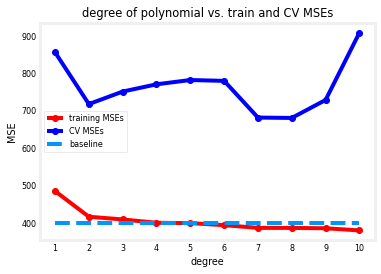

In [17]:
# Split the dataset into train, cv, and test
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset('../data/c2w3_lab2_data1.csv')

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")

# Preview the first 5 rows
print(f"first 5 rows of the training inputs (1 feature):\n {x_train[:5]}\n")

# Instantiate the regression model class
model = LinearRegression()

# Train and plot polynomial regression models
train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=400)


As you can see, the more polynomial features you add, the better the model fits to the training data. In this example, it even performed better than the baseline. At this point, you can say that the models with degree greater than 4 are low-bias because they perform close to or better than the baseline.

However, if the baseline is defined lower (e.g. you consulted an expert regarding the acceptable error), then the models are still considered high bias. You can then try other methods to improve this.

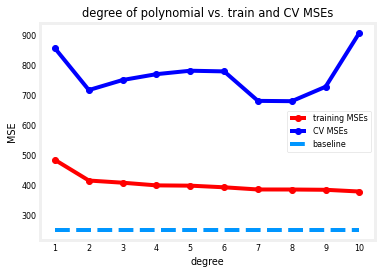

In [19]:
# Train and plot polynomial regression models. Bias is defined lower.
train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=250)

### Try getting additional features

Another thing you can try is to acquire other features. Let's say that after you got the results above, you decided to launch another data collection campaign that captures another feature. Your dataset will now have 2 columns for the input features as shown below.

In [21]:
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset('../data/c2w3_lab2_data2.csv')

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")

# Preview the first 5 rows
print(f"first 5 rows of the training inputs (2 features):\n {x_train[:5]}\n")

the shape of the training set (input) is: (60, 2)
the shape of the training set (target) is: (60,)

the shape of the cross validation set (input) is: (20, 2)
the shape of the cross validation set (target) is: (20,)

first 5 rows of the training inputs (2 features):
 [[3.75757576e+03 5.49494949e+00]
 [2.87878788e+03 6.70707071e+00]
 [3.54545455e+03 3.71717172e+00]
 [1.57575758e+03 5.97979798e+00]
 [1.66666667e+03 1.61616162e+00]]



Now see what this does to the same training process as before. You'll notice that the training error is now closer to (or even better than) the baseline.

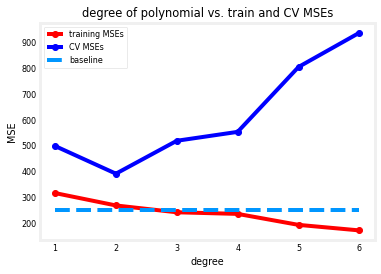

In [22]:
# Instantiate the model class
model = LinearRegression()

# Train and plot polynomial regression models. Dataset used has two features.
train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=6, baseline=250)

### Try decreasing the regularization parameter

At this point, you might want to introduce regularization to avoid overfitting. One thing to watch out for is you might make your models underfit if you set the regularization parameter too high. The cell below trains a 4th degree polynomial model using the [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) class which allows you to set a regularization parameter (i.e. lambda or $\lambda$). You will try several values and compare the results.

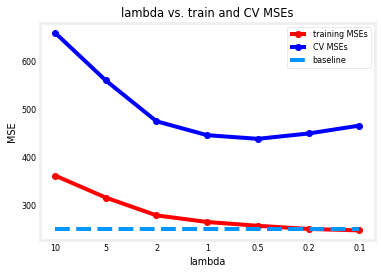

In [25]:
# Define lambdas to plot
reg_params = [10, 5, 2, 1, 0.5, 0.2, 0.1]

# Define degree of polynomial and train for each value of lambda
train_plot_reg_params(reg_params, x_train, y_train, x_cv, y_cv, degree= 4, baseline=250)

The resulting plot shows an initial $\lambda$ of `10` and as you can see, the training error is worse than the baseline at that point. This implies that it is placing a huge penalty on the `w` parameters and this prevents the model from learning more complex patterns in your data. As you decrease $\lambda$, the model loosens this restriction and the training error is able to approach the baseline performance.

## Fixing High Variance

You will now look at some things to try when your model has overfit the training set. The main objective is to have a model that generalizes well to new examples so you want to minimize the cross validation error.

### Try increasing the regularization parameter

In contrast to the last exercise above, setting a very small value of the regularization parameter will keep the model low bias but might not do much to improve the variance. As shown below, you can improve your cross validation error by increasing the value of $\lambda$.

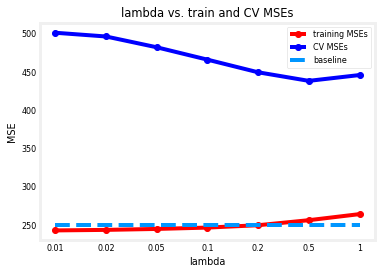

In [26]:
# Define lambdas to plot
reg_params = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

# Define degree of polynomial and train for each value of lambda
train_plot_reg_params(reg_params, x_train, y_train, x_cv, y_cv, degree= 4, baseline=250)

### Try smaller sets of features

You've already seen in the last lab that having too many polynomial terms can result in overfitting. You can reduce the number of such terms and see where you get the best balance of training and cross validation error. Another scenario where reducing the number of features would be helpful is when you have irrelevant features in your data. For example, patient IDs that hospitals give will not help in diagnosing a tumor so you should make sure to remove it from your training data. 

To illustrate how removing features can improve performance, you will do polynomial regression for 2 datasets: the same data you used above (2 features) and another with a random ID column (3 features). You can preview these using the cell below. Notice that 2 columns are identical and a 3rd one is added to include random numbers.

In [32]:
# Prepare dataset with randomID feature
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset('../data/c2w3_lab2_data2.csv')

# Preview the first 5 rows
print(f"first 5 rows of the training set with 2 features:\n {x_train[:5]}\n")

# Prepare dataset with randomID feature
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset('../data/c2w3_lab2_data3.csv')

# Preview the first 5 rows
print(f"first 5 rows of the training set with 3 features (1st column is a random ID):\n {x_train[:5]}\n")

first 5 rows of the training set with 2 features:
 [[3.75757576e+03 5.49494949e+00]
 [2.87878788e+03 6.70707071e+00]
 [3.54545455e+03 3.71717172e+00]
 [1.57575758e+03 5.97979798e+00]
 [1.66666667e+03 1.61616162e+00]]

first 5 rows of the training set with 3 features (1st column is a random ID):
 [[1.41929130e+07 3.75757576e+03 5.49494949e+00]
 [1.51868310e+07 2.87878788e+03 6.70707071e+00]
 [1.92662630e+07 3.54545455e+03 3.71717172e+00]
 [1.25222490e+07 1.57575758e+03 5.97979798e+00]
 [1.76537960e+07 1.66666667e+03 1.61616162e+00]]



Now you will train the models and plot the results. The solid lines in the plot show the errors for the data with 2 features while the dotted lines show the errors for the dataset with 3 features. As you can see, the one with 3 features has higher cross validation error especially as you introduce more polynomial terms. This is because the model is also trying to learn from the random IDs even though it has nothing to do with the target. 

Another way to look at it is to observe the points at degree=4. You'll notice that even though the *training error* is lower with 3 features, the *gap between the training error and cross validation error* is a lot wider than when you only use 2 features. This should also warn you that the model is overfitting.

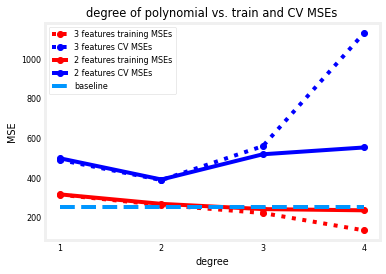

In [34]:
# Define the model
model = LinearRegression()

# Define properties of the 2 datasets
file1 = {'filename':'../data/c2w3_lab2_data3.csv', 'label': '3 features', 'linestyle': 'dotted'}
file2 = {'filename':'../data/c2w3_lab2_data2.csv', 'label': '2 features', 'linestyle': 'solid'}
files = [file1, file2]

# Train and plot for each dataset

train_plot_diff_datasets(model, files, max_degree=4, baseline=250)

### Get more training examples

Lastly, you can try to minimize the cross validation error by getting more examples. In the cell below, you will train a 4th degree polynomial model then plot the *learning curve* of your model to see how the errors behave when you get more examples.

the shape of the entire training set (input) is: (600, 2)
the shape of the entire training set (target) is: (600,)

the shape of the entire cross validation set (input) is: (200, 2)
the shape of the entire cross validation set (target) is: (200,)



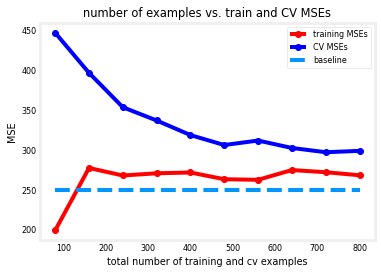

In [36]:
# Prepare the dataset
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset('../data/c2w3_lab2_data4.csv')
print(f"the shape of the entire training set (input) is: {x_train.shape}")
print(f"the shape of the entire training set (target) is: {y_train.shape}\n")
print(f"the shape of the entire cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the entire cross validation set (target) is: {y_cv.shape}\n")

# Instantiate the model class
model = LinearRegression()

# Define the degree of polynomial and train the model using subsets of the dataset.
train_plot_learning_curve(model, x_train, y_train, x_cv, y_cv, degree= 4, baseline=250)

From the results, it shows that the cross validation error starts to approach the training error as you increase the dataset size. Another insight you can get from this is that adding more examples will not likely solve a high bias problem. That's because the training error remains relatively flat even as the dataset increases.

## Wrap Up

In this lab, you were able to practice how to address high bias and high variance in your learning algorithm. By learning how to spot these issues, you have honed your intuition on what to try next when developing your machine learning models. In the next lectures, you will look deeper into the machine learning development process and explore more aspects that you need to take into account when working on your projects. See you there!